## 보험료 예측

Age: 피보험자의 나이  
Sex: 피보험자의 성별  
BMI: 피보험자의 체질량 지수 (몸무게/키^2)   
Children: 피보험자의 자녀의 수  
Smoker: 흡연 여부 (yes / no)  
Region: 피보험자가 거주하는 지역 (Southeast / Southwest / Northeast / Northwest)  
Charges: 보험료

In [ ]:
# library import
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, StandardScaler, 
                                   MinMaxScaler, PowerTransformer, QuantileTransformer)
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

warnings.filterwarnings(action='ignore')

### 데이터 불러오기

In [1]:
import pandas as pd
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### EDA

In [2]:
df.info() #변수, 결측치 여부, 자료형 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
df.describe() #수치형 자료에만 작동

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


children처럼 평균과 std가 비슷한 경우는 매우 넓게 분포 됨 의미. 

### 시각화  
종속변수 charges 제외한 6개 feature 분포 확인

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

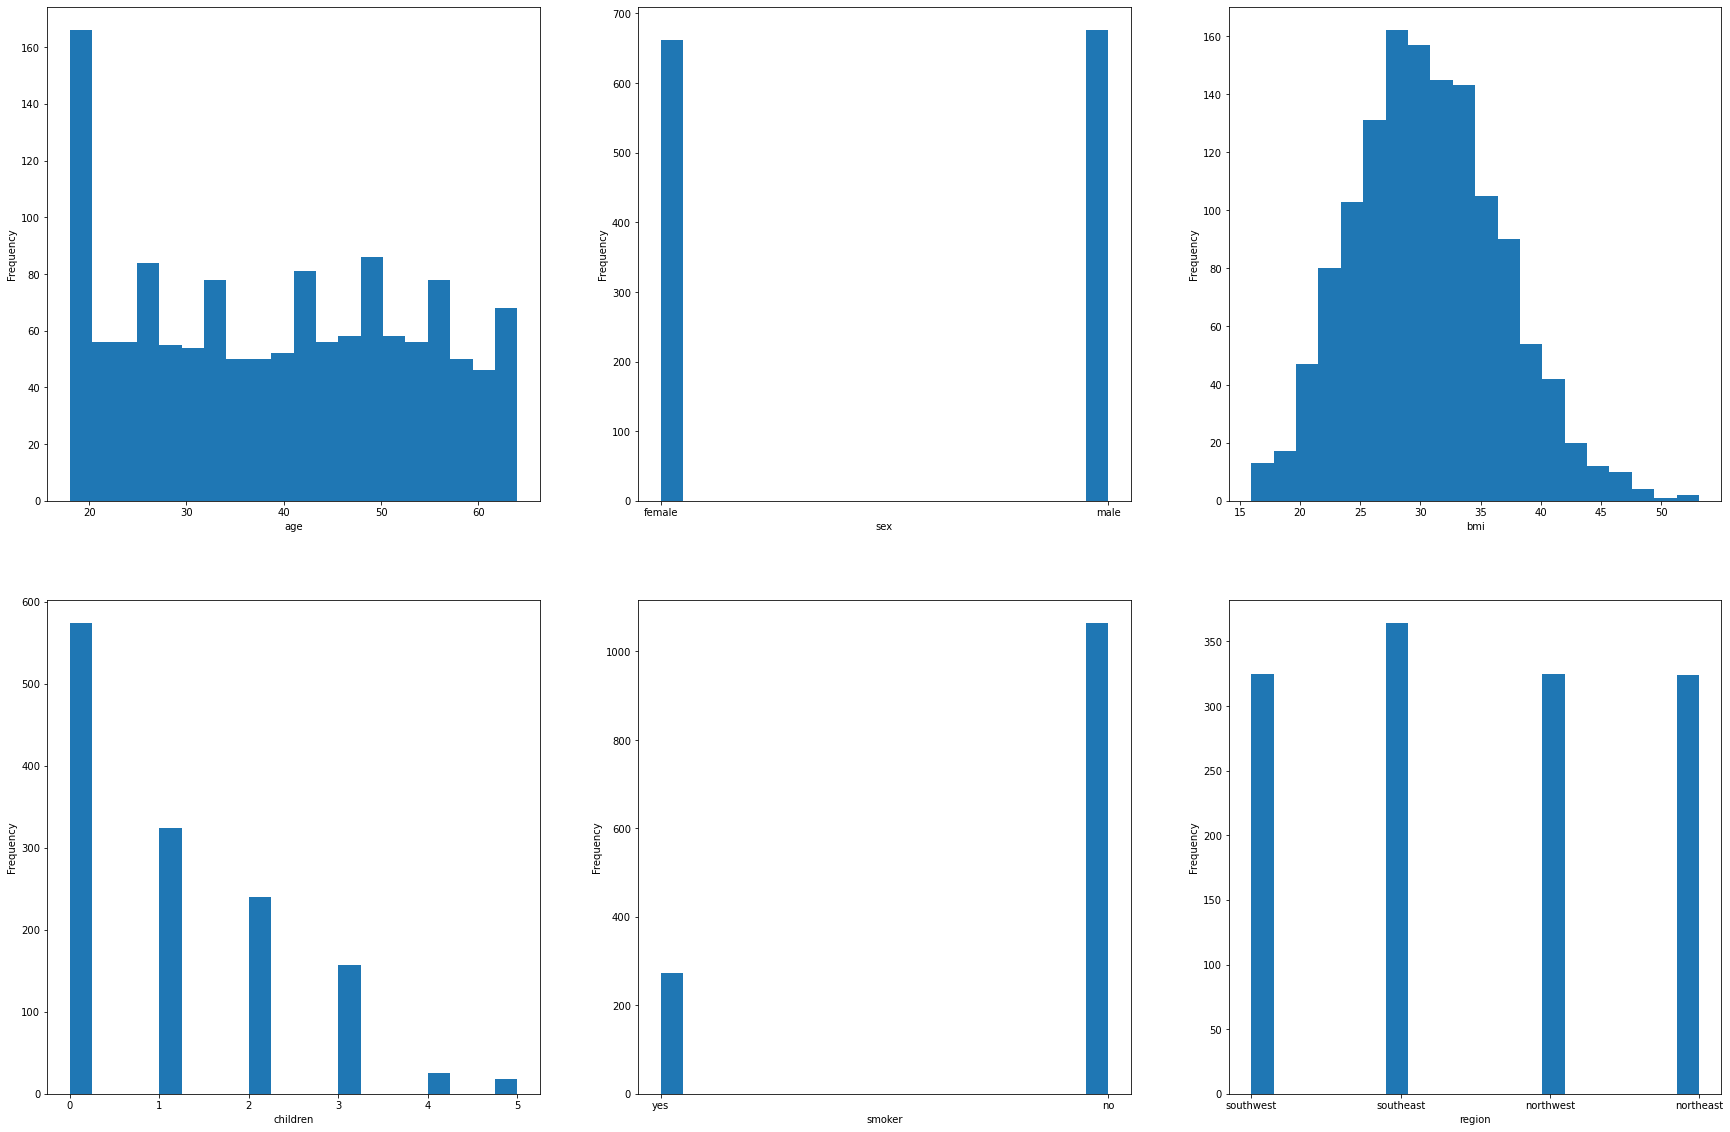

In [5]:
fig, ax = plt.subplots(2,3, figsize =(30,20))

idx=0

for i in range(2):
    for j in range(3):
        colname = list(df.columns)[idx]
        ax[i][j].hist(df[colname], bins=20)
        ax[i][j].set_xlabel(colname)
        ax[i][j].set_ylabel('Frequency')
        idx+=1


20대 미만의 분포 많음. 자녀 0명이 많은 것과 관련있어 보임.  

### 상관관계 파악 및 구간 만들기

In [6]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='bmi', ylabel='age'>,
        <AxesSubplot:xlabel='children', ylabel='age'>,
        <AxesSubplot:xlabel='charges', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='bmi'>,
        <AxesSubplot:xlabel='bmi', ylabel='bmi'>,
        <AxesSubplot:xlabel='children', ylabel='bmi'>,
        <AxesSubplot:xlabel='charges', ylabel='bmi'>],
       [<AxesSubplot:xlabel='age', ylabel='children'>,
        <AxesSubplot:xlabel='bmi', ylabel='children'>,
        <AxesSubplot:xlabel='children', ylabel='children'>,
        <AxesSubplot:xlabel='charges', ylabel='children'>],
       [<AxesSubplot:xlabel='age', ylabel='charges'>,
        <AxesSubplot:xlabel='bmi', ylabel='charges'>,
        <AxesSubplot:xlabel='children', ylabel='charges'>,
        <AxesSubplot:xlabel='charges', ylabel='charges'>]], dtype=object)

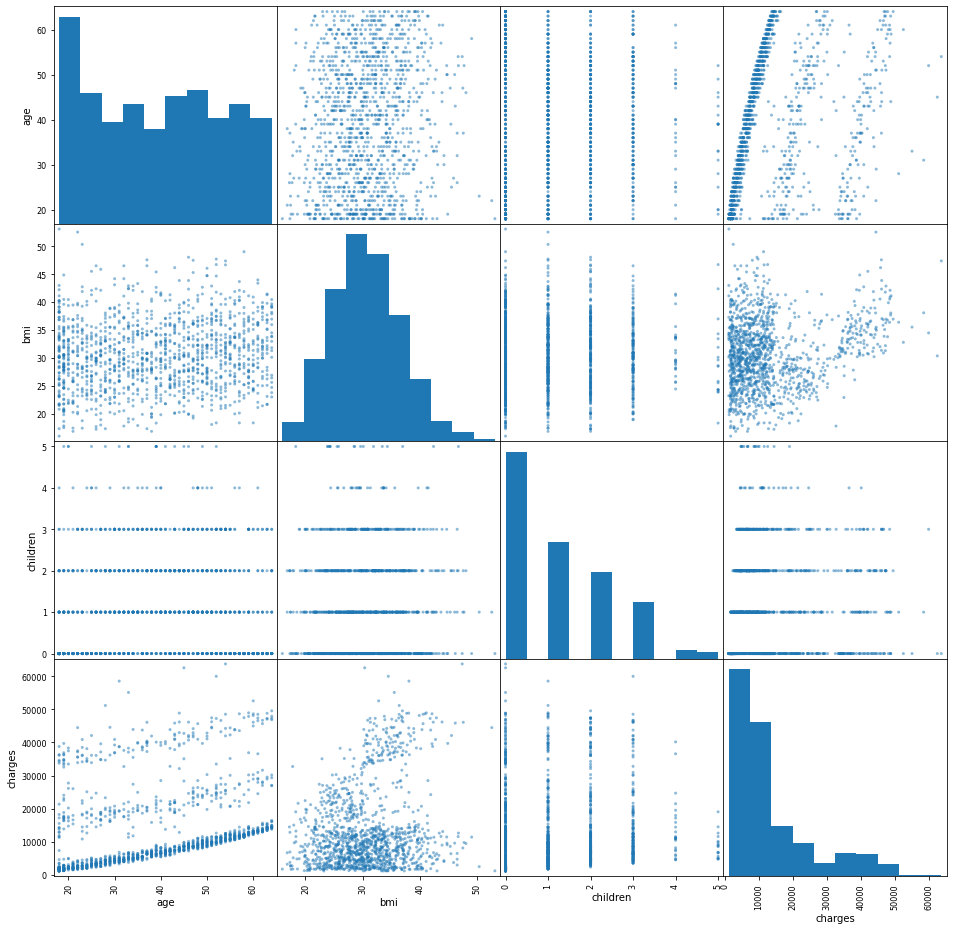

In [7]:
pd.plotting.scatter_matrix(df, figsize=(16,16))

1. age와 charges 사이의 상관계수 높아 보임. (왼쪽 하단)  
2. 20대 이하에 많은 데이터 -> 이 분포를 고려해서 train/test set 나눔

In [8]:
print(df['age'].min(), df['age'].max())

18 64


나이 최소가 18이니, 20대 이하 분포는 18-19에 몰려있다.  
이를 감안하기 위해 연령별 구간 나눌때 20부터는 5세 단위로 끊음

In [9]:
import numpy as np
bins = [0,20,25,30,35,40,45,50,55,60,np.inf]
# pd.cut() : 수치형 변수 범주화해줌
# age_bin은 뒤에 층화추출용 변수
df['age_bin'] = pd.cut(df['age'], bins, labels=[i+1 for i in range(len(bins)-1)]) #막대개수10개
df.head()

,age,sex,bmi,children,smoker,region,charges,age_bin
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,1
2,28,male,33.000,3,no,southeast,4449.46200,3
3,33,male,22.705,0,no,northwest,21984.47061,4
4,32,male,28.880,0,no,northwest,3866.85520,4


(array([166., 140., 138., 130., 127., 137., 144., 140., 125.,  91.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

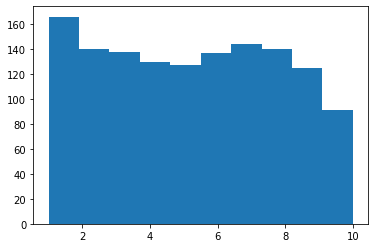

In [10]:
plt.hist(df['age_bin'])

분포 얼추 비슷하게 됨.

### 이상치 탐지

<AxesSubplot:ylabel='bmi'>

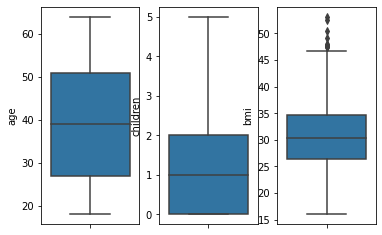

In [11]:
plt.subplot(1,3,1)
sns.boxplot(data=df, y='age')
plt.subplot(1,3,2)
sns.boxplot(data=df, y ='children')
plt.subplot(1,3,3)
sns.boxplot(data=df, y ='bmi')

이상치는 종속변수를 예측하는데 있어 영향을 많이 미치는 변수를 중심으로 제거하는 것이 중요!

In [12]:
#IQR로 이상치 파악하기
bmi_q1 = df['bmi'].quantile(q=0.25)
bmi_q3 = df['bmi'].quantile(q=0.75)
iqr = bmi_q3 - bmi_q1

out1 = df['bmi'] < (bmi_q1 - (1.5 * iqr))
out2 = df['bmi'] > (bmi_q3 + (1.5 * iqr))
outliers = df[out1|out2] #boolean 형태, 합집합 
outliers

,age,sex,bmi,children,smoker,region,charges,age_bin
116,58,male,49.06,0,no,southeast,11381.32540,9
286,46,female,48.07,2,no,northeast,9432.92530,7
401,47,male,47.52,1,no,southeast,8083.91980,7
543,54,female,47.41,0,yes,southeast,63770.42801,8
847,23,male,50.38,1,no,southeast,2438.05520,2
860,37,female,47.60,2,yes,southwest,46113.51100,5
1047,22,male,52.58,1,yes,southeast,44501.39820,2
1088,52,male,47.74,1,no,southeast,9748.91060,8
1317,18,male,53.13,0,no,southeast,1163.46270,1


In [13]:
outliers.index #이 인덱스 활용하여 원래 데이터에서 이상치 제거

Int64Index([116, 286, 401, 543, 847, 860, 1047, 1088, 1317], dtype='int64')

In [14]:
df.drop(outliers.index,axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1329 non-null   int64   
 1   sex       1329 non-null   object  
 2   bmi       1329 non-null   float64 
 3   children  1329 non-null   int64   
 4   smoker    1329 non-null   object  
 5   region    1329 non-null   object  
 6   charges   1329 non-null   float64 
 7   age_bin   1329 non-null   category
dtypes: category(1), float64(2), int64(2), object(3)
memory usage: 84.8+ KB


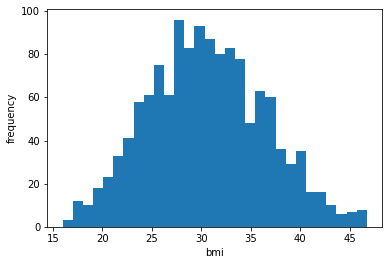

In [15]:
plt.figsize = (10, 10)
plt.hist(df['bmi'], bins=30)
plt.xlabel('bmi')
plt.ylabel('frequency')
plt.show()

### Scaling 
  
- 단위를 조정하는 작업

주로 쓰는 패키지 : Scikit-learn의 MinMaxScaler / StandardScaler  

fit : 변수의 평균,표준편차 / 최대최소 학습  
transform : fit에서 학습한 결과에 따라 변수 변환  
fit_transform : 동시에
  
💥 scaling할때는 train set에만 fitting을 하고 test set에는 하지 않음!! 💥 

train에 fit 사용하고, 그 결과를 가지고 train과 test를 변환 (Data Leakage 방지)

In [16]:
#수치형 변수
to_scale = ['age','bmi','children','charges']
df_to_scale = df[to_scale].copy()

### Normal Transformation  
- 변수의 분포를 바꾸는 작업  
- 변수가 정규분포 일수록 학습이 잘 됨 -> 주로 정규분포로 변환  
  
정규분포로 바꾸는 방법 : 로그변환 / Power transformation / Quantile Transformation
- np.log / Scikit-learn.preprocessing의 power_transform, QuantileTransformer

In [17]:
# Quantile Transformation
# 미리 정한 분포에 따라서 상응하는 값을 반환 (여기서는 정규분포) -> 내가 원하는 분포로 바뀜
from sklearn.preprocessing import QuantileTransformer

quantile = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
q = quantile.fit_transform(df_to_scale)
q_df = pd.DataFrame(q, columns=to_scale)

# Power Transformation
# Box-cox 변환과 Yeo-Johnson 변환 (밑은 여-존슨 변환)
from sklearn.preprocessing import PowerTransformer

power = PowerTransformer(method='yeo-johnson')
yj = power.fit_transform(df_to_scale)
yj_df = pd.DataFrame(yj, columns=to_scale)


# Log Transformation
# np.log 사용
# 변수에 0이 포함된 경우 np.log1p 사용
import numpy as np
log_df = pd.DataFrame(np.log1p(df_to_scale), columns=to_scale)

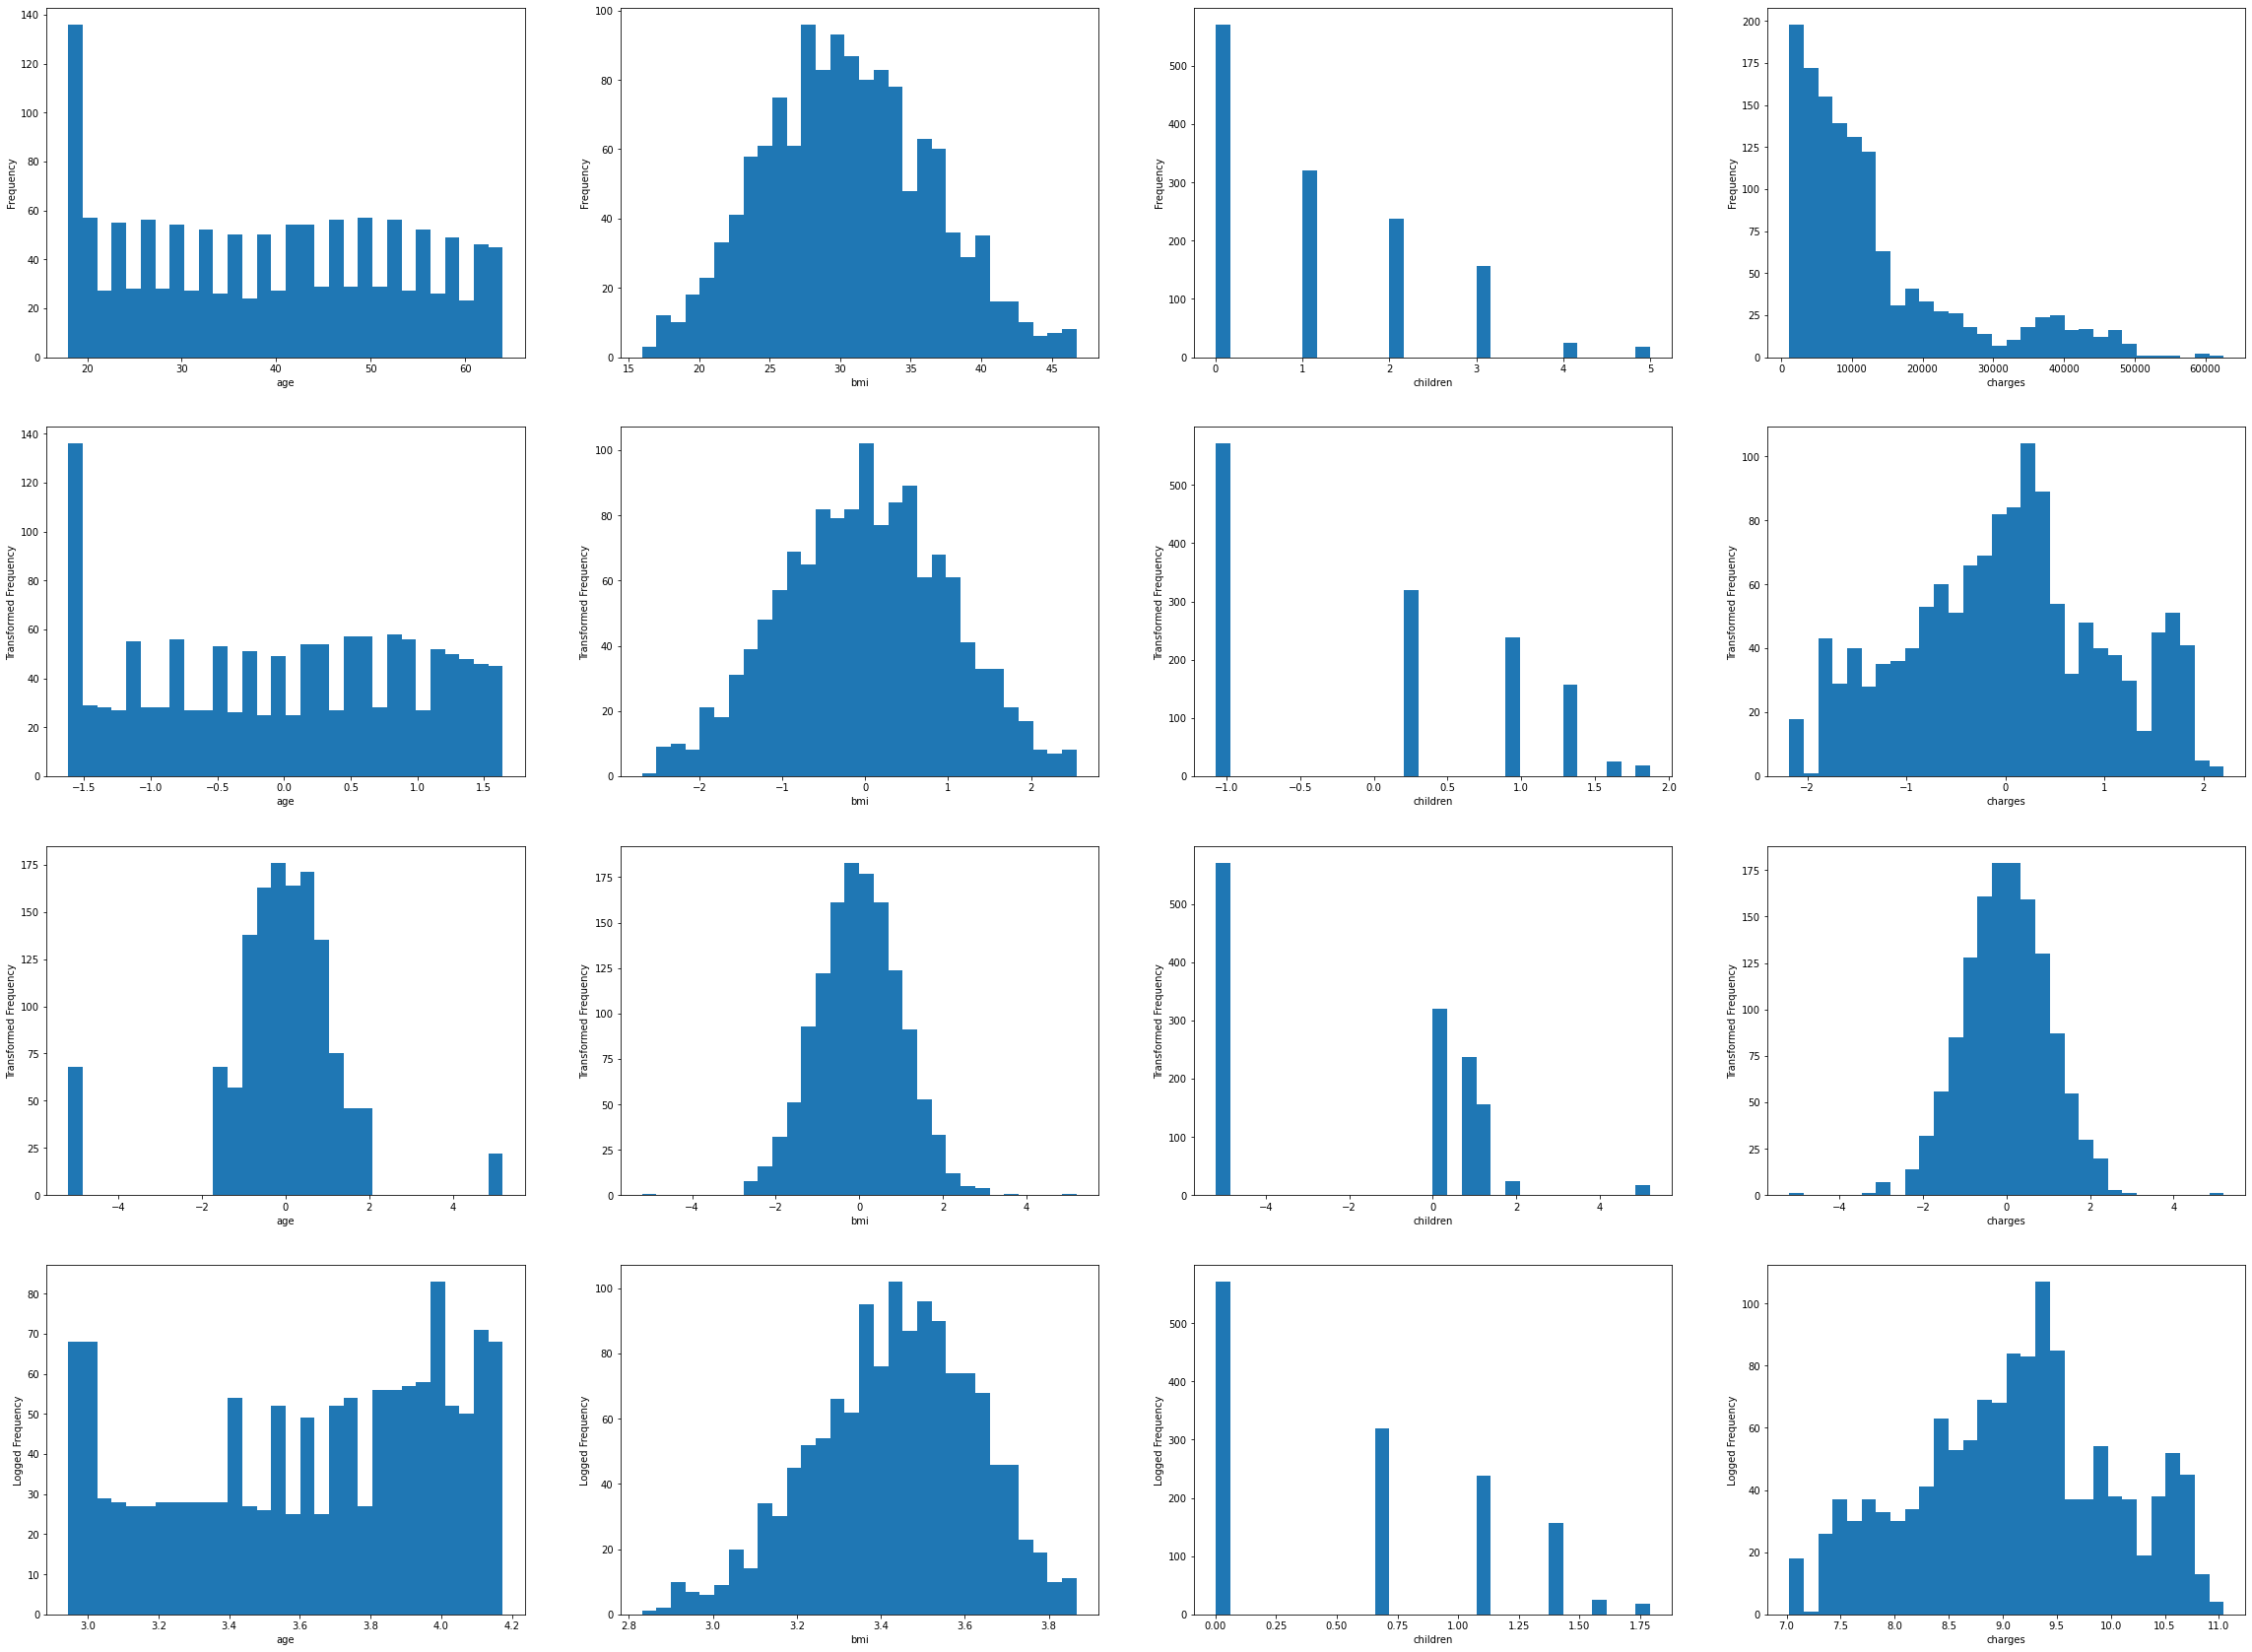

In [18]:
# 시각화
fig,ax = plt.subplots(4,4,figsize=(40,30))
for i in range(4):
    idx = 0
    for j in range(4):
        colname = to_scale[idx]
        if i == 0: #그냥
            ax[i][j].hist(df_to_scale[colname], bins = 30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Frequency')
        elif i == 1: #power transformation
            ax[i][j].hist(yj_df[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Transformed Frequency')
        elif i == 2: #quantile transformation
            ax[i][j].hist(q_df[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Transformed Frequency')
        elif i == 3: #log transformation
            ax[i][j].hist(log_df[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Logged Frequency')
            
        idx += 1
            
# 그래프는 열별로 보기   
# Quantile 이랑 Power 변환한 애들(2,3행) 정규분포에 가까워짐

### Train set / Test set 분리

In [19]:
from sklearn.model_selection import train_test_split

X = df.drop(['charges'], axis=1)
y = df['charges']

#앞서 EDA에서 확인한 age 분포 고려 + age와 charges의 상관관계 높음 -> 층화샘플링 
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, 
                                         shuffle=True,stratify=X['age_bin'])
X_train

,age,sex,bmi,children,smoker,region,age_bin
339,46,female,27.720,1,no,southeast,7
1157,23,female,23.180,2,no,northwest,2
1211,39,male,34.100,2,no,southeast,5
918,61,female,28.200,0,no,southwest,10
485,31,female,31.065,0,no,northeast,4
...,...,...,...,...,...,...,...
824,60,male,24.320,0,no,northwest,9
943,19,male,22.610,0,no,northwest,1
597,34,female,33.250,1,no,northeast,4
789,62,female,29.920,0,no,southeast,10


#### sklearn 변환하는 애들(encoding,transforming) 보아하니 2차원 배열/데이터프레임이 input으로 들어가야 함  
  
  🔥 LabelEncoder는 1차원!

In [20]:
import warnings
warnings.filterwarnings(action='ignore')

#분리한 set 변환
to_scale=['age','bmi']

q=QuantileTransformer(n_quantiles=10,random_state=0, output_distribution='normal')

# train에 fit하고 학습 결과를 train/test 둘 다에 transform!!!
for col in to_scale:
    q.fit(X_train[[col]]) #2D 배열
    X_train[col] = q.transform(X_train[[col]]).flatten() #transform하면 숫자가 각각 리스트 형태-> flatten으로 하나의 리스트로 만들어줌
    X_test[col] = q.transform(X_test[[col]]).flatten()
    
print(X_train.isnull().sum(),'\n')
print(X_test.isnull().sum())
X_train.describe()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
age_bin     0
dtype: int64 

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
age_bin     0
dtype: int64


,age,bmi,children
count,996.000000,996.000000,996.000000
mean,-0.092707,-0.009218,1.081325
std,1.568660,0.946938,1.197322
min,-5.199338,-5.199338,0.000000
25%,-0.645631,-0.694585,0.000000
50%,-0.027855,-0.008481,1.000000
75%,0.692077,0.632955,2.000000
max,5.199338,5.199338,5.000000


In [21]:
# 데이터 표준화
# 변수들의 단위를 맞춰주는 작업
# 얼추 위에서 맞춘거 같긴한데 확실히 하기 위해
cols =['age','bmi','children']

from sklearn.preprocessing import StandardScaler
s = StandardScaler()

for col in cols:
    s.fit(X_train[[col]])
    X_train[col] = s.transform(X_train[[col]]).flatten() #transform하면 숫자가 각각 리스트 형태
    X_test[col] = s.transform(X_test[[col]]).flatten()

X_train.describe() #진짜 제대로 N(0,1)

,age,bmi,children
count,9.960000e+02,9.960000e+02,9.960000e+02
mean,9.140390e-18,2.519181e-17,1.695710e-17
std,1.000502e+00,1.000502e+00,1.000502e+00
min,-3.257045e+00,-5.483703e+00,-9.035734e-01
25%,-3.526586e-01,-7.241355e-01,-9.035734e-01
50%,4.136316e-02,7.791907e-04,-6.795677e-02
75%,5.005410e-01,6.784984e-01,7.676599e-01
max,3.375304e+00,5.503182e+00,3.274510e+00


### Encoding  
범주형인 sex,smoker, region을 인코딩

In [22]:
from sklearn.preprocessing import OneHotEncoder

## Sex
one = OneHotEncoder(drop='first') #기준범주 빼고 (남자가 1, 여자가 0 )
one.fit(X_train[['sex']])
sex_train_one = one.transform(X_train[['sex']]).toarray() #transform하면 sparse matrix -> toarray하면 숫자가 각각 리스트 형태
sex_test_one = one.transform(X_test[['sex']]).toarray() 

# 원래 데이터 갱신
X_train['sex'] = sex_train_one[:,0].astype(int) #각각 리스트라 [:,0]으로 슬라이싱
X_test['sex'] = sex_test_one[:,0].astype(int)

## Smoker
one = OneHotEncoder(drop='first') #기준범주 빼고 (Yes가 1, No가 0 )
one.fit(X_train[['smoker']])
smoker_train_one = one.transform(X_train[['smoker']]).toarray() #transform하면 sparse matrix -> toarray하면 숫자가 각각 리스트 형태
smoker_test_one = one.transform(X_test[['smoker']]).toarray() 

# 원래 데이터 갱신
X_train['smoker'] = smoker_train_one[:,0].astype(int) #각각 리스트라 [:,0]으로 슬라이싱
X_test['smoker'] = smoker_test_one[:,0].astype(int)

In [23]:
# 라벨인코딩 안하고 원핫 가도 되는데 연습용으로
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
le.fit(X_train['region']) # 라벨 인코딩의 input은 1차원!!!!

X_train['region'] = le.transform(X_train['region'])
X_test['region'] = le.transform(X_test['region'])

X_train.head()

,age,sex,bmi,children,smoker,region,age_bin
339,0.295350,0,-0.447513,-0.067957,0,2,7
1157,-0.530120,0,-1.286343,0.767660,0,1,2
1211,0.041363,1,0.615830,0.767660,0,2,5
918,1.075296,0,-0.365860,-0.903573,0,3,10
485,-0.215592,0,0.139277,-0.903573,0,0,4


In [24]:
## Region
one = OneHotEncoder(drop='first') #기준범주 빼고 
one.fit(X_train[['region']])
region_train_one = one.transform(X_train[['region']]).toarray() #transform하면 sparse matrix -> toarray하면 숫자가 각각 리스트 형태
region_test_one = one.transform(X_test[['region']]).toarray() 

#pd.DataFrame(region_train_one) : 이것도 방법이긴 한데 인덱스 맞추려면 아래 방법으로,,

X_train['region_1'] = region_train_one[:, 0].astype(int) 
X_train['region_2'] = region_train_one[:, 1].astype(int) 
X_train['region_3'] = region_train_one[:, 2].astype(int) 

X_test['region_1'] = region_test_one[:, 0].astype(int)
X_test['region_2'] = region_test_one[:, 1].astype(int)
X_test['region_3'] = region_test_one[:, 2].astype(int)


In [25]:
# 인코딩한 애들 원래 모습은 지워주자.
X_train.drop(['region','age_bin'],axis=1,inplace=True)
X_test.drop(['region','age_bin'],axis=1,inplace=True)
X_train

,age,sex,bmi,children,smoker,region_1,region_2,region_3
339,0.295350,0,-0.447513,-0.067957,0,0,1,0
1157,-0.530120,0,-1.286343,0.767660,0,1,0,0
1211,0.041363,1,0.615830,0.767660,0,0,1,0
918,1.075296,0,-0.365860,-0.903573,0,0,0,1
485,-0.215592,0,0.139277,-0.903573,0,0,0,0
...,...,...,...,...,...,...,...,...
824,0.981464,1,-1.045558,-0.903573,0,1,0,0
943,-0.957037,1,-1.343576,-0.903573,0,1,0,0
597,-0.120870,0,0.485560,-0.067957,0,0,0,0
789,1.198352,0,-0.077130,-0.903573,0,0,1,0


### Model Selection 
- 다중선형회귀, 엘라스틱넷  
- Decision Tree  
- Random Forest  
- AdaBoost, GradientBoost, XGBoost, LGBM, CatBoost

In [26]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(996, 8) (996,)
(333, 8) (333,)


In [27]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#### 기본 default 모델 여러개 해보고 TOP 4 뽑아서 튜닝!

In [28]:
lr = LinearRegression()
enet = ElasticNet(random_state=42)
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
ada = AdaBoostRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
cat = CatBoostRegressor(silent=True, random_state=42)

models = [lr, enet, dt, rf, ada, gbr, xgb, lgbm, cat]

In [31]:
from sklearn.model_selection import cross_val_score


for model in models:
    name = model.__class__.__name__
    
    # scores 변수에 cross validation한 5개 결과값(MSE) 저장
    scores = cross_val_score(model, X=X_train, y = y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=-1) # n_jobs : 병렬작업 / scoring : 네거티브,, 그렇대,,
    
    # 5개의 MSE 평균 
    mse = (-1) * np.mean(scores)
    
    print('Model %s - RMSE: %.4f' %(name,np.sqrt(mse)))

Model LinearRegression - RMSE: 6349.4021
Model ElasticNet - RMSE: 9564.7996
Model DecisionTreeRegressor - RMSE: 6102.9064
Model RandomForestRegressor - RMSE: 4696.4935
Model AdaBoostRegressor - RMSE: 5229.6733
Model GradientBoostingRegressor - RMSE: 4532.1122
Model XGBRegressor - RMSE: 5082.5939
Model LGBMRegressor - RMSE: 4812.3896
Model CatBoostRegressor - RMSE: 4684.0945


## Hyperparameter Tuning  
 GradientBoosting / CatBoost / RandomForest / LGBM

In [32]:
from sklearn.model_selection import GridSearchCV

In [38]:
# Gradient Boosting
gbr_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 80, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 5],
    'random_state': [42]
}

# gbr_search에 그리드 서치 + 5fold CV 적용한 모든 모델 결과 저장
gbr_search = GridSearchCV(gbr, param_grid=gbr_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gbr_search.fit(X_train, y_train)

# mse 제일 낮은 모델 선택
best_mse = (-1) * gbr_search.best_score_
best_rmse = np.sqrt(best_mse)

print('Best score: {}, Best params: {}'.format(round(best_rmse, 4), gbr_search.best_params_))

Best score: 4424.5085, Best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


In [35]:
# Random Forest
rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 5],
    'random_state': [42]
}

rf_search = GridSearchCV(gbr, param_grid=rf_params, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
rf_search.fit(X_train, y_train)
best_mse = (-1) * rf_search.best_score_
best_rmse = np.sqrt(best_mse)

print('Best score: {}, Best params: {}'.format(round(best_rmse,4), rf_search.best_params_))

Best score: 4478.3086, Best params: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


In [36]:
# LGBM
lgbm_params = {
    'num_leaves': [25, 31, 35],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 7, 11],
    'random_state': [42]
}

lgbm_search = GridSearchCV(lgbm, param_grid=lgbm_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lgbm_search.fit(X_train, y_train)
best_mse = (-1) * lgbm_search.best_score_
best_rmse = np.sqrt(best_mse)

print('Best score: {}, Best params: {}'.format(round(best_rmse, 4), lgbm_search.best_params_))

Best score: 4477.0474, Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'num_leaves': 25, 'random_state': 42}


In [37]:
# CatBoost
# CatBoost는 categorical feature를 parameter로 넣을 수 있음
cat_features = ['sex', 'smoker', 'region_1', 'region_2', 'region_3']

cat_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 7, 11],
    'cat_features': [cat_features], 
    'silent': [True],
    'random_state': [42]
}

cat_search = GridSearchCV(cat, param_grid=cat_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cat_search.fit(X_train, y_train)
best_mse = (-1) * cat_search.best_score_
best_rmse = np.sqrt(best_mse)

print('Best score: {}, Best params: {}'.format(round(best_rmse, 4), cat_search.best_params_))

Best score: 4430.7722, Best params: {'cat_features': ['sex', 'smoker', 'region_1', 'region_2', 'region_3'], 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 42, 'silent': True}


### Test 및 결과 확인

In [43]:
from sklearn.metrics import mean_squared_error

In [44]:
# Gradient Boosting
gbr_final = GradientBoostingRegressor(**gbr_search.best_params_)

gbr_final.fit(X_train, y_train)
y_pred_gbr = gbr_final.predict(X_test)
name = gbr_final.__class__.__name__

# Test RMSE
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print('RMSE of %s: %.4f' % (name, np.sqrt(mse_gbr)))

RMSE of GradientBoostingRegressor: 4746.1145


In [45]:
# RandomForest
rf_final = RandomForestRegressor(**rf_search.best_params_)

rf_final.fit(X_train, y_train)
y_pred_rf = rf_final.predict(X_test)

name = rf_final.__class__.__name__

# Test RMSE
mse_rf = mean_squared_error(y_test, y_pred_rf)
print('RMSE of %s: %.4f' % (name, np.sqrt(mse_rf)))

RMSE of RandomForestRegressor: 4890.1950


In [46]:
# LGBM
lgbm_final = LGBMRegressor(**lgbm_search.best_params_)

lgbm_final.fit(X_train, y_train)
y_pred_lgbm = lgbm_final.predict(X_test)

name = lgbm_final.__class__.__name__

# Test RMSE
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
print('RMSE of %s: %.4f' % (name, np.sqrt(mse_lgbm)))

RMSE of LGBMRegressor: 4827.4415


In [47]:
# CatBoost
cat_final = CatBoostRegressor(**cat_search.best_params_)

cat_final.fit(X_train, y_train)
y_pred_cat = cat_final.predict(X_test)

name = cat_final.__class__.__name__

# Test RMSE
mse_cat = mean_squared_error(y_test, y_pred_cat)
print('RMSE of %s: %.4f' % (name, np.sqrt(mse_cat)))

RMSE of CatBoostRegressor: 4724.2351
